In [ ]:
import os
os.environ['HF_HOME'] = '/scratch/ss13750/huggingface'
os.environ['HF_HUB_CACHE'] = '/scratch/ss13750/huggingface'
os.environ["HF_TOKEN"] = ""

In [2]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
import nnsight
from nnsight import LanguageModel
from nnsight import CONFIG
import torch
import torch.nn.functional as F
import random
import datasets
from typing import Optional, List, Dict, Tuple
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

/scratch/ss13750/conda-envs/nnsight/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from IPython.display import clear_output
try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

if is_colab:
    !pip install --no-deps nnsight
    !pip install msgspec python-socketio[client]
    !pip install -U datasets

clear_output()

In [5]:
# Model configuration. For loading a model not supported by NDIF, set REMOTE to False.
REMOTE = False # set to True to use the NDIF hosted model
# model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
# model_name = "Qwen/Qwen2.5-1.5B-Instruct"
# model_name = "Qwen/Qwen2.5-0.5B-Instruct"
# model_name="Qwen/Qwen2.5-3B"
# model_name="Qwen/Qwen2.5-7B-Instruct"
# model_name = "/scratch/ss13750/nnsight/out_models/Qwen_Qwen2_5-7B-Instruct__4-5-11-12-17-20-24"
# model_name = "/scratch/ss13750/rl/outputs/gkd_qwen7b_dolci_v1/checkpoint-6000"
# model_name = "allenai/OLMo-2-0425-1B"
# model_name = "allenai/OLMo-2-1124-7B-SFT"
# model_name="mistralai/Mistral-7B-Instruct-v0.3"
# model_name = "deepseek-ai/deepseek-llm-7b-chat"
# model_name = "/scratch/ss13750/nnsight/out_models/meta-llama_Llama-3_1-8B-Instruct__22-23-24-25-26-27-28-29"
# model_name = "/scratch/ss13750/nnsight/out_models/merged_llama_8cossim_checkpoint9000"
model_name="google/gemma-2-2b-it"

N_EXAMPLES = 1000 # Number of examples for the future effect tests.
if REMOTE:
    if is_colab:
        # include your HuggingFace Token and NNsight API key on Colab secrets
        from google.colab import userdata
        NDIF_API = userdata.get('NDIF_API')
        HF_TOKEN = userdata.get('HF_TOKEN')

        CONFIG.set_default_api_key(NDIF_API)
        !huggingface-cli login -token HF_TOKEN
    else:
        nnsight.CONFIG.API.APIKEY = os.environ["NDIF_API"]

clear_output()

In [6]:
def load_model():
    if not REMOTE:
        from transformers import BitsAndBytesConfig
    #     bnb_config = BitsAndBytesConfig(
    #         load_in_8bit=True,
    #         bnb_8bit_compute_dtype=torch.bfloat16
    #     )
        llm = LanguageModel(model_name, device_map="auto", 
    #                         quantization_config=bnb_config, 
                            torch_dtype=torch.bfloat16)
    else:
        llm = LanguageModel(model_name)
    
    llm.eval()
    return llm

llm = load_model()
print(llm)

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

In [7]:
llm.device

device(type='meta')

In [8]:
# Dataset for the GSM8K benchmark.
class GSM8K:
    def __init__(self):
        self.dataset = datasets.load_dataset("openai/gsm8k", "main", split="test")

    @staticmethod
    def format_example(example: Dict[str, str]) -> str:
        # Format GSM8K example according to the LM evaluation harness.
        question = example["question"]
        answer = example["answer"].split("####")
        assert len(answer) == 2
        res = f"Given the following problem, reason and give a final answer to the problem.\nProblem: {question}\nYour response should end with \"The final answer is [answer]\" where [answer] is the response to the problem.\n"
        return f"{res}\n{answer[0]}The final answer is {answer[1].strip()}"

    def __iter__(self):
        for example in self.dataset:
            yield self.format_example(example)

In [9]:
# Dataset for the GSM8K benchmark.
class SlimPajama:
    def __init__(self):
        self.dataset = datasets.load_dataset("DKYoon/SlimPajama-6B", split="validation", streaming=True)

    @staticmethod
    def format_example(example: Dict[str, str]) -> str:
        return example['text']

    def __iter__(self):
        for example in self.dataset:
            yield self.format_example(example)

In [10]:
# Dataset for the GSM8K benchmark.
class C4:
    def __init__(self):
        self.dataset = datasets.load_dataset("allenai/c4", "en", split="validation", streaming=True)

    @staticmethod
    def format_example(example: Dict[str, str]) -> str:
        return example['text']

    def __iter__(self):
        for example in self.dataset:
            yield self.format_example(example)

In [11]:
# Dataset for the GSM8K benchmark.
class Omega:
    def __init__(self):
        self.dataset = datasets.load_dataset("allenai/omega-explorative", "logic_gridworld_knight_move", split="train")

    @staticmethod
    def format_example(example: Dict[str, str]) -> str:
        # Format GSM8K example according to the LM evaluation harness.
        question = example["messages"][0]["content"]
        answer = example["ground_truth"]

        res = f"{question}"
        return f"{res}\nThe final answer is {answer}"

    def __iter__(self):
        for example in self.dataset:
            yield self.format_example(example)

In [12]:
def tokenize(llm: LanguageModel, prompt: str, add_special_tokens: bool = True) -> List[str]:
    # Tokenize a prompt and return the tokens as a list of strings.
    tokens = llm.tokenizer(prompt, add_special_tokens=add_special_tokens)["input_ids"]
    token_str = [s.replace("Ġ","_") for s in llm.tokenizer.convert_ids_to_tokens(tokens)]
    return token_str

In [13]:
prompts = []
dataset = GSM8K

for i, prompt in enumerate(dataset()):
    if i >= 100:
        break
    prompts.append(prompt)

In [17]:
sum([len(llm.tokenizer(prompt)['input_ids']) for prompt in prompts])

22660

In [18]:
# target_layers = [22]
# noise_std = 0.01

# model_edited = edit_model(llm, target_layers, noise_std)

In [22]:
import torch.nn.functional as F
import gc

def get_layer_input_tensor(layer_inputs):
    """Extract the actual input tensor from potentially nested structure"""
    current = layer_inputs
    
    # Keep unpacking tuples until we get a tensor
    while isinstance(current, tuple):
        current = current[0]
    
    return current

def analyze_cos(llm, prompts):
    all_cosines = []
    
    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:
            for j, prompt in tqdm(enumerate(prompts), total=len(prompts)):
                with llm.trace(prompt):
                    cosine_similarities = []
                    try:
                        for i, layer in enumerate(llm.model.layers):
                            #input_ids = input_ids.to(llm.device)
                            # layer.inputs gives back a tuple with two elements
                            # first entry is another tuple with one element which has the inputs
                            # in shape of 1x tokens x hidden dim
                            # second entry is dict with keys: ['attention_mask', 'position_ids', 'past_key_value', 'use_cache', 'cache_position', 'position_embeddings']
                            # layer.output is simply a tensor with shape 1x tokens x hidden dim
                            
                            
                            layer_inputs = get_layer_input_tensor(layer.inputs)  # Save the input
                            layer_output = layer.output       # Save the original output
                            
                            # Make sure layer_output is also a tensor (in case it's wrapped)
                            if isinstance(layer_output, tuple):
                                layer_output = get_layer_input_tensor(layer_output)

                            # Calculate cosine similarity between input and output
                            # layer_inputs and layer_output shape: (1, seq_len, hidden_dim)
                            input_flat = layer_inputs.view(-1, layer_inputs.size(-1))    # (seq_len, hidden_dim)
                            output_flat = layer_output.view(-1, layer_output.size(-1))   # (seq_len, hidden_dim)

                            # Calculate cosine similarity for each token position
                            cos_sim = F.cosine_similarity(input_flat.detach().cpu().float(), output_flat.detach().cpu().float(), dim=1)  # (seq_len,)
                            avg_cosine_similarity = cos_sim.mean().item().save()  # Average across all tokens
                            cosine_similarities.append(avg_cosine_similarity)
                            
                        all_cosines.append(cosine_similarities)
                        
                    except Exception as e:
                        print(f"\nError in layer {i}, prompt {j}: {e}")
                        # Emergency cleanup
                        torch.cuda.empty_cache()
                        gc.collect()
                        #continue
                    
                    finally:
                        # Periodic memory cleanup
                        if j % 3 == 0:  # Every 3 prompts
                            torch.cuda.empty_cache()
                            gc.collect()
                    
    return all_cosines

In [23]:
torch.__version__

'2.4.0+cu121'

In [24]:
data = analyze_cos(llm, prompts[:1000])

100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


In [25]:
cossims = np.array(data).mean(axis=0)

In [26]:
import matplotlib.pyplot as plt

def lineplot_with_annotations(data, title="Line Plot", xlabel="Index", ylabel="Value", 
                              annotate_format="{:.2f}", figsize=(8,5)):
    """
    Creates a line plot with annotated data points.
    
    Parameters:
    - data: A list or 1D numpy array of values.
    - title, xlabel, ylabel: Plot labels.
    - annotate_format: Format string for annotations (e.g., "{:.2f}" or "{}").
    - figsize: Figure size (width, height).
    """
    x = list(range(len(data)))
    y = data

    plt.figure(figsize=figsize)
    plt.plot(x, y, marker='o', linestyle='-', linewidth=2, markersize=6)
    
    # Annotate each point
    for xi, yi in zip(x, y):
        plt.text(xi, yi + 0.02, annotate_format.format(yi),
                 ha='center', va='bottom', fontsize=6,
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", lw=0.5, alpha=0.8))
    
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


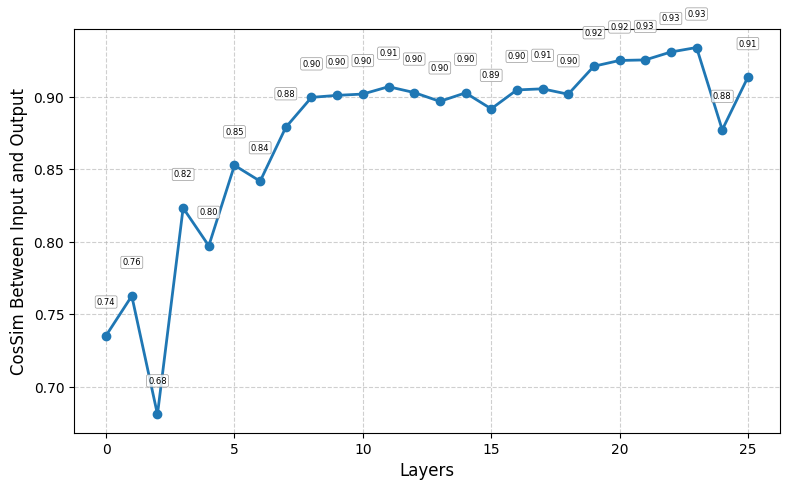

In [27]:
lineplot_with_annotations(cossims, xlabel="Layers", ylabel="CosSim Between Input and Output", title=None)